In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
customers = pd.read_csv('data/customers.csv')
transactions = pd.read_csv('data/transactions.csv')


In [3]:
customers.head(10)

,CustomerID,CustomerName,Region,SignupDate
0,C0001,Lawrence Carroll,South America,2022-07-10
1,C0002,Elizabeth Lutz,Asia,2022-02-13
2,C0003,Michael Rivera,South America,2024-03-07
3,C0004,Kathleen Rodriguez,South America,2022-10-09
4,C0005,Laura Weber,Asia,2022-08-15
5,C0006,Brittany Palmer,South America,2024-01-07
6,C0007,Paul Graves,Asia,2022-06-18
7,C0008,David Li,North America,2024-01-13
8,C0009,Joy Clark,Europe,2023-08-14
9,C0010,Aaron Cox,Europe,2022-12-15


In [4]:
transactions.head(10)

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68
5,T00442,C0188,P067,2024-12-26 14:40:03,1,300.68,300.68
6,T00490,C0195,P067,2024-11-24 11:49:48,3,902.04,300.68
7,T00536,C0008,P067,2024-09-22 06:13:59,1,300.68,300.68
8,T00564,C0157,P067,2024-12-07 17:57:40,3,902.04,300.68
9,T00631,C0130,P067,2024-05-14 23:14:59,2,601.36,300.68


In [5]:
customers.isna().sum()

CustomerID      0
CustomerName    0
Region          0
SignupDate      0
dtype: int64

In [6]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CustomerID    200 non-null    object
 1   CustomerName  200 non-null    object
 2   Region        200 non-null    object
 3   SignupDate    200 non-null    object
dtypes: object(4)
memory usage: 6.4+ KB


In [7]:
transactions.isna().sum()

TransactionID      0
CustomerID         0
ProductID          0
TransactionDate    0
Quantity           0
TotalValue         0
Price              0
dtype: int64

In [8]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TransactionID    1000 non-null   object 
 1   CustomerID       1000 non-null   object 
 2   ProductID        1000 non-null   object 
 3   TransactionDate  1000 non-null   object 
 4   Quantity         1000 non-null   int64  
 5   TotalValue       1000 non-null   float64
 6   Price            1000 non-null   float64
dtypes: float64(2), int64(1), object(4)
memory usage: 54.8+ KB


#### `LTV`

In [9]:

customer_ltv = transactions.groupby('CustomerID')['TotalValue'].sum().reset_index()
customer_ltv.columns = ['CustomerID', 'LTV']

#### `Recency`

In [10]:
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])
last_purchase = transactions.groupby('CustomerID')['TransactionDate'].max().reset_index()
last_purchase['Recency'] = (pd.to_datetime('today') - last_purchase['TransactionDate']).dt.days
last_purchase = last_purchase[['CustomerID', 'Recency']]

In [11]:

customers = pd.merge(customers, customer_ltv, on='CustomerID', how='left')
customers = pd.merge(customers, last_purchase, on='CustomerID', how='left')

In [12]:
customers.isna().sum()

CustomerID      0
CustomerName    0
Region          0
SignupDate      0
LTV             1
Recency         1
dtype: int64

`Missing values removal from LTV and Recency columns`

In [13]:
numeric_columns = customers.select_dtypes(include=['float64', 'int64']).columns
customers[numeric_columns] = customers[numeric_columns].fillna(customers[numeric_columns].median())

non_numeric_columns = customers.select_dtypes(exclude=['float64', 'int64']).columns
customers[non_numeric_columns] = customers[non_numeric_columns].fillna(customers[non_numeric_columns].mode().iloc[0])

print(customers.isnull().sum())

CustomerID      0
CustomerName    0
Region          0
SignupDate      0
LTV             0
Recency         0
dtype: int64


In [14]:
features = customers[['LTV', 'Recency']]

In [15]:

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

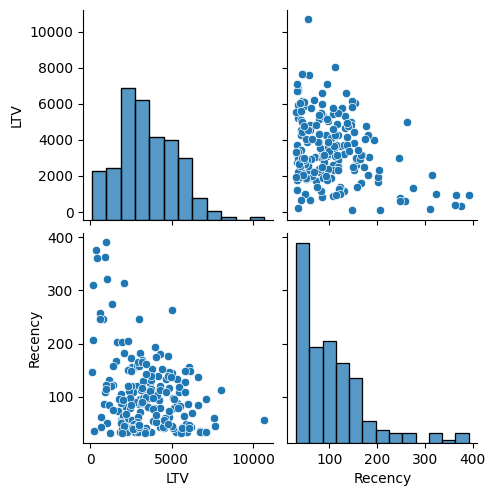

In [18]:

sns.pairplot(customers[['LTV', 'Recency']])
plt.show()

### `Using Kmeans Clustering to visualize clusters`

DB Index for 2 clusters: 1.045746457702576
DB Index for 3 clusters: 0.8267968723571641
DB Index for 4 clusters: 0.8195954063984197
DB Index for 5 clusters: 0.8534652430484758
DB Index for 6 clusters: 0.8013601093759443
DB Index for 7 clusters: 0.839160950500137
DB Index for 8 clusters: 0.8578448374555762
DB Index for 9 clusters: 0.7878815614363723
DB Index for 10 clusters: 0.8507865631219744


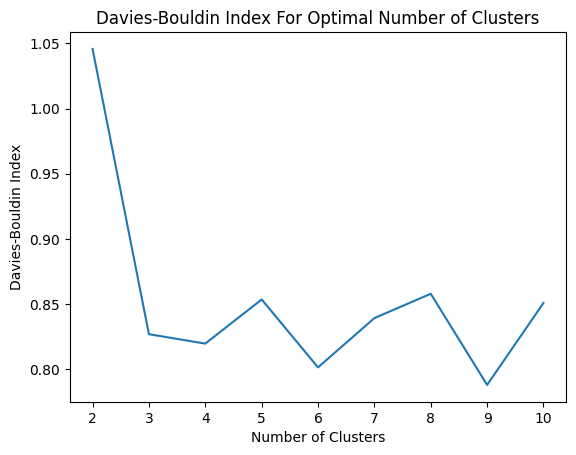

In [21]:
db_indices = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    db_index = davies_bouldin_score(scaled_features, kmeans.labels_)
    db_indices.append(db_index)
    print(f"DB Index for {k} clusters: {db_index}")

plt.plot(range(2, 11), db_indices)
plt.title('Davies-Bouldin Index For Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.show()

In [20]:

num_clusters = 5

kmeans = KMeans(n_clusters=num_clusters, random_state=42)
customers['Cluster'] = kmeans.fit_predict(scaled_features)
cluster_centers = kmeans.cluster_centers_

db_index = davies_bouldin_score(scaled_features, customers['Cluster'])
print(f"DB Index: {db_index}")

DB Index: 0.8534652430484758


### `Using PCA to visualize clusters`

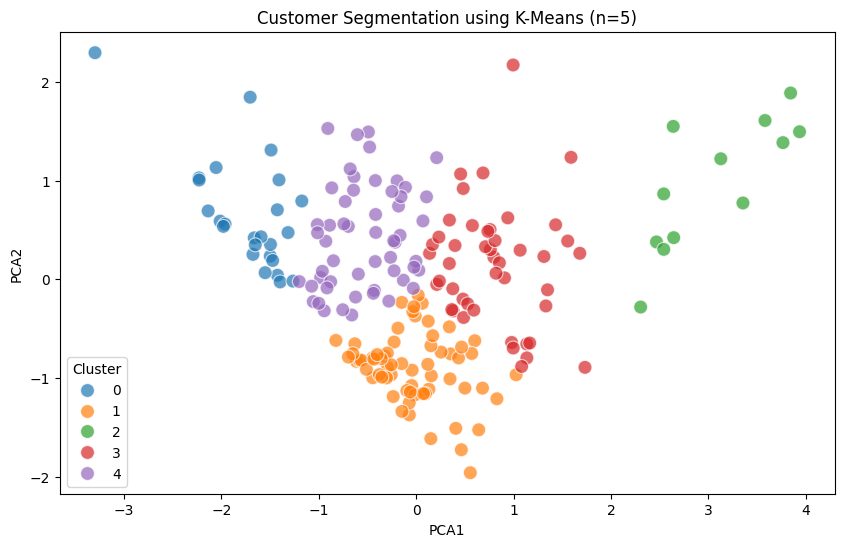

In [25]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_features)

customers['PCA1'] = pca_components[:, 0]
customers['PCA2'] = pca_components[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=customers, palette='tab10', s=100, alpha=0.7, edgecolor='w')
plt.title(f'Customer Segmentation using K-Means (n={num_clusters})')
plt.show()